# Example usage

## Initialize a GeslaDataset object
Place the `gesla.py` file in your working directory (or elsewhere on your path), and import the `GeslaDataset` class. Selecting and loading data files requires paths to the metadata .csv file and the directory containing the data files. Initialize a `GeslaDataset` object with these paths as follows.

In [1]:
from gesla import GeslaDataset

meta_file = "./GESLA3_ALL.csv"
data_path = "./GESLA3.0_ALL/"

g3 = GeslaDataset(meta_file=meta_file, data_path=data_path)

/home/tomsail/Documents/scripts/Python/searvey/.venv/lib/python3.10/site-packages/dataretrieval/nadp.py:44: UserWarning: GDAL not installed. Some functions will not work.
  warnings.warn('GDAL not installed. Some functions will not work.')


## Load data from a single file
If you want to work with data from a single record, and you know the filename you want, use the function `file_to_pandas` as follows. The function returns a `pandas.DataFrame` with data and flags, and a `pandas.Series` containing metadata.

In [2]:
filename = "acajutla-082c-slv-uhslc"
data, meta = g3.file_to_pandas(filename)
data

,sea_level,qc_flag,use_flag
date_time,,,
2010-08-19 21:00:00,1.064,1,1
2010-08-19 22:00:00,0.905,1,1
2010-08-19 23:00:00,0.871,1,1
2010-08-20 00:00:00,0.998,1,1
2010-08-20 01:00:00,1.198,1,1
...,...,...,...
2018-12-31 19:00:00,1.563,1,1
2018-12-31 20:00:00,1.246,1,1
2018-12-31 21:00:00,1.001,1,1


<Axes: xlabel='date_time'>

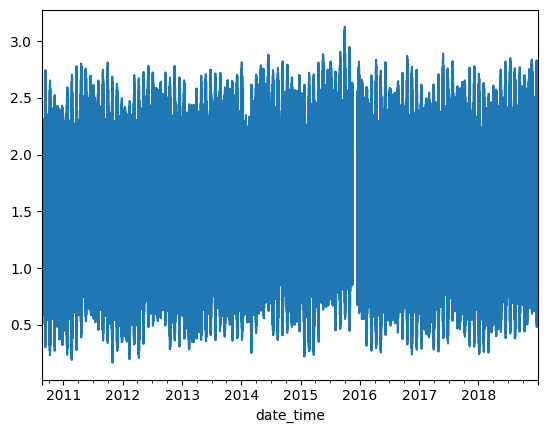

In [3]:
data.where(data.use_flag==1).sea_level.plot()

## Load data from a list of files
If you want to work with data from multiple files, and you know the filenames you want, use the function `files_to_xarray` as follows. The function returns a `xarray.Dataset` object containing data, flags, and metadata.

In [4]:
filenames = [
    "abrams_river-380-can-meds",
    "acajutla-082c-slv-uhslc", 
    "yoshioka-hd26-jpn-jodc_jcg", 
    "west_point_a_la_hache-8761494-usa-noaa",
]
xr_dataset = g3.files_to_xarray(filenames)
print(xr_dataset)

<xarray.Dataset>
Dimensions:                  (date_time: 289251, station: 4)
Coordinates:
  * date_time                (date_time) datetime64[ns] 1971-06-09T05:00:00 ....
  * station                  (station) int64 0 1 2 3
Data variables: (12/27)
    sea_level                (station, date_time) float64 2.29 1.79 ... nan nan
    qc_flag                  (station, date_time) float64 1.0 1.0 ... nan nan
    use_flag                 (station, date_time) float64 1.0 1.0 ... nan nan
    filename                 (station) object 'acajutla-082c-slv-uhslc' ... '...
    site_name                (station) object 'Acajutla' ... 'Abrams_River'
    site_code                (station) object '082C' 'HD26' '8761494' '380'
    ...                       ...
    datum_information        (station) object 'Unspecified' ... 'Chart Datum ...
    instrument               (station) object 'Unspecified' ... 'Unspecified'
    precision                (station) object 'Unspecified' ... 'Unspecified'
    null_va

## Load data from the N closest records to a lat/lon location
Load data from records close to a particular location using the function `load_N_closest` as follows. Provide a lat/lon location and the number of desired records. The function returns a `xarray.Dataset` object containing data, flags, and metadata.  

Note the `UserWarning` that occurs when duplicate timestamps are encountered. The function `file_to_pandas` used to read each individual file keeps only the first of any duplicate timestamps.

In [5]:
data = g3.load_N_closest(lat=43.83, lon=-65.95, N=10)
print(data.site_name.values)

/home/tomsail/Documents/scripts/Python/GeslaDataset/gesla.py:74: UserWarning: Duplicate timestamps in file yarmouth-365-can-meds were removed.
  warnings.warn(


['Yarmouth' 'Lower_Wedgeport' 'Pinkney_Point' 'Abbotts_Harbour'
 'Clarks_Harbour' 'Woods_Harbour' 'Tusket' 'Abrams_River' 'Flat_Island'
 'Wedgeport']


## Load data from the records in a lat/lon range
Load data from records in a rectangular lat/lon range using the function `load_lat_lon_range` as follows. Provide lat/lon extents of the range. The function returns a `xarray.Dataset` object containing data, flags, and metadata.

In [6]:
south_lat = 15
north_lat = 30
west_lon = -180
east_lon = -140

data = g3.load_lat_lon_range(
    south_lat=south_lat,
    north_lat=north_lat,
    west_lon=west_lon,
    east_lon=east_lon,
)
print(data.site_name.values)

['Honolulu_Hawaii' 'Hilo_Hawaii' 'Midway' 'Johnston' 'Kahului'
 'Nawiliwili' 'Mokuoloe' 'French_Frigate' 'Kawaihae' 'French_Frigate'
 'Barbers_Point_HI' 'Honolulu_Kewalo' 'Port_Allen' 'Kaumalapau_HI'
 'Honolulu_Hawaii' 'Honolulu_Pier_45' 'Honolulu' 'Hilo' 'Nawiliwili'
 'Sand_Island' 'Kahului' 'Mokuoloe' 'Kawaihae' 'Johnston_Atoll'
 'Port_Allen' 'Kaumalapau_Harbor' 'Kaunakakai_Harbor' 'Laiemaloo'
 'Fort_Kamehameha' 'Ford_Island']


## Load data from the records in a region
Load data outside a buffer zone from the coast. 
Say for example that we only want to load data from offshore. 
Here is the procedure of how to to do it, using 
* geopandas
* cartopy
* shapely
* and [searvey](https://github.com/oceanmodeling/searvey)

In [7]:
import shapely
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.feature as cf
import geopandas as gp
import xarray as xr

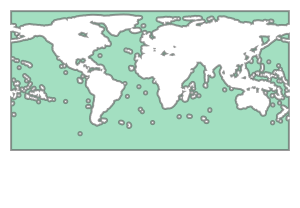

In [14]:
gh = cf.GSHHSFeature(scale="intermediate", levels=[1])
wo = gp.GeoDataFrame(geometry=[x for x in gh.geometries()])

BUFFER_SIZE = 2

coords = ((-180.,-90.), (-180., 90.), (180., 90.), (180.,-90.), (-180.,-90.))
polygon = shapely.Polygon(coords)

coast_buffer = shapely.ops.unary_union(wo.geometry.buffer(BUFFER_SIZE))

offshore = polygon.difference(coast_buffer)
offshore

In [9]:
data = g3.load_lat_lon_range(offshore)
data

/home/tomsail/Documents/scripts/Python/GeslaDataset/gesla.py:74: UserWarning: Duplicate timestamps in file rothera-rot-gbr-noc were removed.
  warnings.warn(


<xarray.Dataset>
Dimensions:                  (date_time: 1300505, station: 27)
Coordinates:
  * date_time                (date_time) datetime64[ns] 1952-05-01T15:00:00 ....
  * station                  (station) int64 0 1 2 3 4 5 6 ... 21 22 23 24 25 26
Data variables: (12/27)
    sea_level                (station, date_time) float64 nan nan ... nan nan
    qc_flag                  (station, date_time) float64 nan nan ... nan nan
    use_flag                 (station, date_time) float64 nan nan ... nan nan
    filename                 (station) object 'faraday-700a-ata-uhslc' ... 'd...
    site_name                (station) object 'Faraday' ... 'D151'
    site_code                (station) object '700A' '127A' ... 'A12' 'D15'
    ...                       ...
    datum_information        (station) object 'Unspecified' ... 'MSL'
    instrument               (station) object 'Unspecified' ... 'Unspecified'
    precision                (station) object 'Unspecified' ... 'Unspecified'
    null_value               (station) float64 -100.0 -100.0 ... -100.0 -100.0
    gauge_type               (station) object 'Coastal' 'Coastal' ... 'Coastal'
    overall_record_quality   (station) object 'No obvious issues' ... 'No obv...

/tmp/ipykernel_33128/2459521265.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


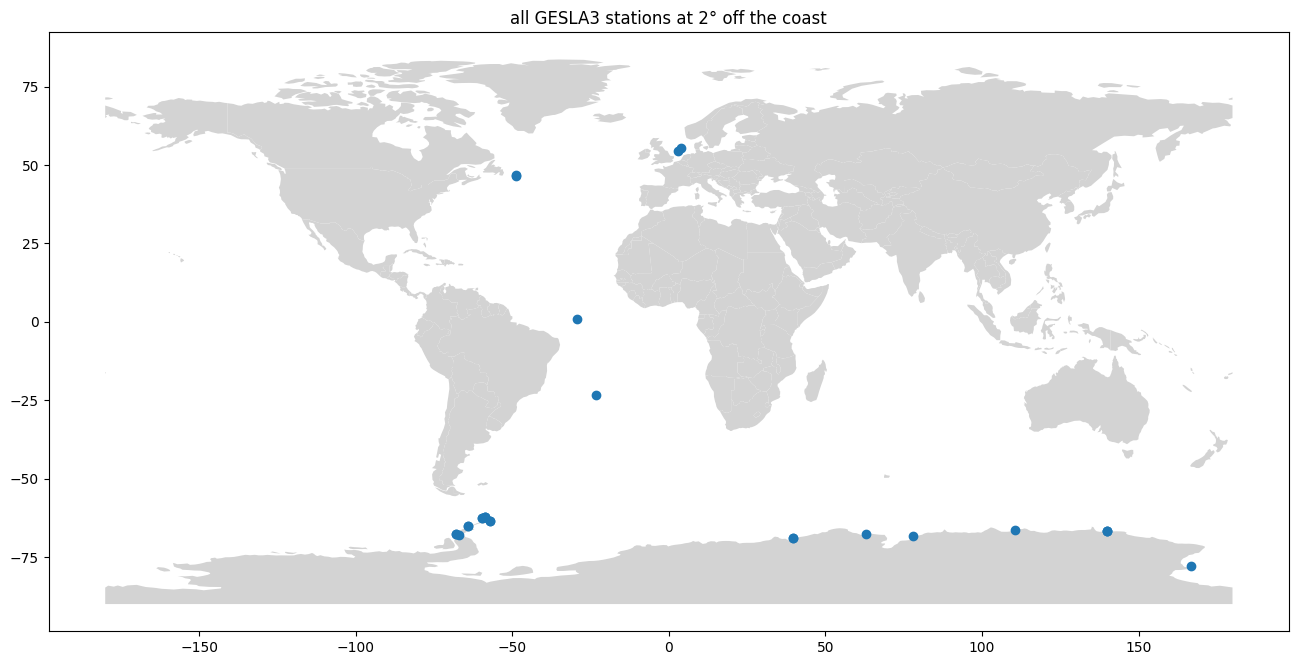

In [10]:
figure, axis = plt.subplots(1, 1)
figure.set_size_inches(16, 16 / 1.61803398875)

countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
_ = countries.plot(color='lightgrey', ax=axis, zorder=-1)
_ = axis.scatter(data.longitude, data.latitude)
_ = axis.set_title(f'all GESLA3 stations at '+str(BUFFER_SIZE)+'° off the coast')